# Lid driven cavity problem

BC are:
- top -> shifting wall: BC = 0, BC' = (K, 0)
- left, right, bot -> static wall with drag: BC = 0, BC' = 0
  


In [1]:
# Choose a theme to your convenience
PLOTLY_THEME = "plotly_dark"
#PLOTLY_THEME = "plotly_white"


In [2]:
from __future__ import annotations

from dataclasses import dataclass


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets import *
from IPython.display import display
import napari
from tqdm import tqdm
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from decimal import Decimal
import json


class CFDResult:
    def __init__(self, all_u: np.array, simu: CFDSimulation):
        self.all_u = all_u
        self.simu = simu
        self.all_norms = np.linalg.norm(all_u, axis=3)

    def plot_velocities(self, constant_scale=False):
        u = np.swapaxes(self.all_u, 1, 2)  # invert axe for napari
        u = np.pad(u, ((0, 0), (0, 0), (0, 0), (0, 1))) # pad last dim to be 3 so napari thinks its rgb
        viewer = napari.imshow(u)

    def max_dt_over_time(self, CFL, auto_plot=True, **kwargs):
        max_velo = np.linalg.norm(self.all_u, axis=(3)).max(axis=(1, 2))
        max_dt = CFL * self.simu.dx / max_velo 
        plt.plot(list(range(len(max_dt))), max_dt, label=f're={self.simu.re}, N={self.simu.N}, dt={self.simu.dt}')
        plt.title(f"Max estimated dt at CFL: {CFL}")
        plt.legend()
        if auto_plot:
            plt.show()

    def energy_over_time(self, auto_plot=True, **kwargs):
        
        # We use a proxy formula for energy defined as sum of squared norm of velocities
        # all_u of shape [S, N, M, 2]
        energy = (self.all_u ** 2).sum(axis=(1, 2, 3))
        plt.plot(list(range(len(energy))), energy, label=f're={self.simu.re}, N={self.simu.N}, dt={self.simu.dt}')
        plt.title("Proxy energy over time")
        plt.legend()
        if auto_plot:
            plt.show()

    # Meaningless without context
    def re_over_time(self):
        fig, ax = plt.subplots()
        # all_u of shape (S, N, M, 2)
        re_t = np.sqrt(np.mean((self.all_u ** 2).sum(axis=(3)) ** 2, axis=(1, 2))) * self.simu.grid_size[0] / self.simu.nu
        ax.plot(list(range(len(re_t))), re_t)
        ax.set_title("Re over time")
        plt.show()

    def save(self):
        save_folder = 'runs/'
        save_name = self.simu.name + '.npy'
        with open(save_folder + save_name, 'wb') as f:
            np.save(f, self.all_u)
            self.simu.save()

    @classmethod
    def load(cls, simu):
        save_name = 'runs/' + simu.name + '.npy'
        result = cls(np.load(save_name), simu)
        return result

    @classmethod
    def load_from_file(cls, save_name):
        simu = CFDSimulation.load(save_name + '.json')
        
        result = cls(np.load(save_name + '.npy'), simu)
        return result

    def profile_at_time(self, snap, add_ref_data=True, auto_plot=True, **kwargs):
        re_lb = str(self.simu.re)
        
        half_x = self.simu.M // 2 - 1
        uU = self.all_u[snap, half_x, :, 0] / self.simu.K
        yL = np.array(list(range(self.simu.M))[::-1]) * self.simu.dy / 1.0
        plt.plot(yL, uU, label=f'Our: re={re_lb}, N={self.simu.N}, dt={self.simu.dt}')

        if add_ref_data:
            df = pd.read_csv('ghia_ref_u.csv', sep='\\s+')
            if re_lb in df.columns:
                plt.scatter(df['y'], df[re_lb], label=f'Ghia & al re={re_lb}')
            else:
                print(f'No reference data at RE={self.simu.re}') 
                
        plt.ylabel('u/u')
        plt.xlabel('y/L')
        plt.title(f'U profile at x/L = 0.5')
        plt.legend()
        if auto_plot:
            plt.show()
        

In [11]:


INT = np.s_[1:-1, 1:-1]
XINT = np.s_[2:, 1:-1]
XMINT = np.s_[:-2, 1:-1]
YINT = np.s_[1:-1, 2:]
YMINT = np.s_[1:-1, :-2]

class CFDSimulation:
    def __init__(self, re=200, steps=20, dt=1e-4, dsave=1, grid_res=32, desc_refresh=1000, M=32, N=32):
        self.re = re
        self.steps = steps
        self.dt = dt
        self.dsave = dsave
        self.grid_size = (1, 1)
        self.N = grid_res
        self.M = grid_res
        self.dx = self.grid_size[0] / self.N
        self.dy = self.grid_size[1] / self.M
        self.dim = (self.N, self.M, 2)
        self.initial_u = np.random.sample(size=self.dim) * 1e-3
        self.K = 1  # U, lid velocity
        
        self.nu = self.K * self.grid_size[0] / self.re
        print(f'Using nu={self.nu} for target re:{self.re}')
        self.rho = 1
        self.p = np.zeros((self.N, self.M))
        self.curr_u = np.zeros_like(self.initial_u)
        self.saved_u = np.zeros(((self.steps // self.dsave) - 1, self.N, self.M, 2))
        self.save_idx = 0
        self.curr_step = 0
        self.description_refresh = desc_refresh
        self.plot = True
        self.exception = None
        self.CFL = 0.5

    def to_dict(self):
        return {
            're': self.re,
            'steps': self.steps,
            'dt': self.dt,
            'dsave': self.dsave,
            'K': self.K,
            'N': self.N,
            'M': self.M
        }
        
    @classmethod
    def from_dict(cls, d):
        obj = cls(
            re=d.get('re', 200),
            steps=d.get('steps', 20),
            dt=d.get('dt', 1e-4),
            dsave=d.get('dsave', 1),
            M=d.get('M', 32),
            N=d.get('N', 32),
        )
        obj.K = d.get('K', 1)
        return obj

    @property
    def name(self):
        return f'RE{self.re}_dt{self.dt}_{self.N}x{self.M}_K{self.K}_[{self.curr_step}:{self.steps}]:{self.dsave}steps'

    def save(self):
        with open(f"runs/{self.name}.json", "w") as f:
            json.dump(self.to_dict(), f, indent=4)

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            data = json.load(f)
            return cls.from_dict(data)

    def prepare_plot(self):
       
        self.fig = go.FigureWidget(make_subplots(rows=2, cols=2))
        
        self.fig.add_scatter(y=[], mode="lines", name='min', row=1, col=1)
        self.fig.add_scatter(y=[], mode="lines", name='mean', row=1, col=1)
        self.fig.add_scatter(y=[], mode="lines", name='max', row=1, col=1)

        yL = np.array(list(range(self.M))[::-1]) * self.dy / 1.0
        self.fig.add_scatter(x=yL, y=[], mode="lines", name='profile', row=1, col=2)
        re_lb = str(self.re)
        df = pd.read_csv('ghia_ref_u.csv', sep='\\s+')
        if re_lb in df.columns:
            self.fig.add_scatter(x=df['y'], y=df[re_lb], mode="lines", name=f'Ghia & al re={re_lb}', row=1, col=2)

        self.fig.add_scatter(mode="lines", name='max_dt', row=2, col=1)
        self.fig.add_scatter(mode="lines", name='current_dt', row=2, col=1)
        
        self.fig.update_layout(
            template=PLOTLY_THEME,
            height=500,
            width=1500,
            font=dict(size=13),
            margin=dict(l=55, r=20, t=15, b=45),
            xaxis=dict(title="Iteration", showgrid=True),
            yaxis=dict(title="Divergence", showgrid=True),
            
        )
        self._min_div = []
        self._mean_div = []
        self._max_div = []
        self._iter = []
        self._dt = []
        self._max_dt = []
        self.fig.update_traces(line=dict(width=2))
        display(self.fig)
    
    def update_plot(self, min_div, mean_div, max_div):
        
        half_x = self.M // 2 - 1
        uU = self.curr_u[half_x, :, 0] / self.K

        max_velo = np.linalg.norm(self.curr_u, axis=(2)).max()
        max_dt = self.CFL * self.dx / max_velo 
        self._max_dt.append(max_dt)
        self._dt.append(self.dt)
        
        self._iter.append(self.curr_step)
        self._min_div.append(min_div)
        self._mean_div.append(mean_div)
        self._max_div.append(max_div)
        with self.fig.batch_update():
            self.fig.data[0].y = self._min_div
            self.fig.data[0].x = self._iter
            self.fig.data[1].y = self._mean_div
            self.fig.data[1].x = self._iter
            self.fig.data[2].y = self._max_div
            self.fig.data[2].x = self._iter
            
            self.fig.data[3].y = uU
        
            self.fig.data[5].y = self._max_dt
            self.fig.data[5].x = self._iter
            self.fig.data[6].y = self._dt
            self.fig.data[6].x = self._iter

    def save_curr(self):
        
        self.saved_u[self.save_idx] = self.curr_u
        self.save_idx += 1
        # print(f'saving {self.save_idx}')
    
    def compute_convection(s, u):
        s.setup_bc(u)
        conv = np.zeros_like(u)
        for c in [0, 1]:
           dcdx = (u[XINT][..., c] - u[XMINT][..., c]) / (2*s.dx)
           dcdy = (u[YINT][..., c] - u[YMINT][..., c]) / (2*s.dy)
           conv[INT][..., c] = u[INT][..., 0]*dcdx + u[INT][..., 1]*dcdy
        return conv
    
    def compute_viscous_drag(s, u):
        s.setup_bc(u)
        lap = np.zeros_like(u)
        for c in [0, 1]:
            lap[INT][..., c] = (
                (u[XINT][..., c] - 2*u[INT][..., c] + u[XMINT][..., c]) / s.dx**2
              + (u[YINT][..., c] - 2*u[INT][..., c] + u[YMINT][..., c]) / s.dy**2
            )
        return s.nu * lap
        
    def compute_updated_pressure(s, u_star, p_guess, iters=20):
        p = p_guess.copy()
        s.setup_bc(u_star)

        def update_p_ghost():
            p[1:, 0] = p[1:, 1]
            p[1:, -1] = p[1:, -2]
            p[0, 1:] = p[1, 1:]
            p[-1, 1:] = p[-2, 1:]
            p[0,0] = (p[0,1] + p[1,0])/2
            p[0,-1] = (p[0,-2] + p[1,-1])/2
            p[-1,0] = (p[-2,0] + p[-1,1])/2
            p[-1,-1] = (p[-2,-1] + p[-1,-2])/2
            
        update_p_ghost()
        
        rhs = np.zeros_like(p)
        
        rhs[INT] = (
            (u_star[XINT][..., 0] - u_star[XMINT][..., 0]) / (2*s.dx)
          + (u_star[YINT][..., 1] - u_star[YMINT][..., 1]) / (2*s.dy)
        )
        
        pn = p.copy()
        for i in range(iters):
            pn[INT] = (
                (p[XINT] + p[XMINT]) * s.dy**2
              + (p[YINT] + p[YMINT]) * s.dx**2
              - rhs[INT] * s.dx**2 * s.dy**2
            ) / (2*(s.dx**2 + s.dy**2))
            p[:] = pn[:]
    
        return p


    def project_velocity(s, u_star, pressure):
        p = pressure
        s.setup_bc(u_star)
        u = u_star.copy()
        u[INT][..., 0] -= (p[XINT] - p[XMINT]) / (2*s.dx)
        u[INT][..., 1] -= (p[YINT] - p[YMINT]) / (2*s.dy)
        return u

    def compute_divergence(self, u):
        self.setup_bc(u)
        divergence = np.zeros_like(u)
        divergence[INT] = (u[XINT] - u[XMINT]) / 2 + (u[YINT] - u[YMINT]) / 2
        return divergence

    def setup_bc(self, u):
        # (sorry for no notation help)
        # Ut = 2Uw-Ub
        # top - sliding wall
        u[1:-1, 0, 0] = 2 * self.K - u[1:-1, 1, 0]
        #u[1:-1, 0, 0] = - u[1:-1, 1, 0]
        u[1:-1, 0, 1] = - u[1:-1, 1, 1]
        # bot - no slip
        u[1:-1, -1, :] = - u[1:-1, -2, :]
        # left - no slip
        u[0, 1:-1, :] = - u[1, 1:-1, :]
        # right - no slip
        u[-1, 1:-1, :] = - u[-2, 1:-1, :]
        # corners
        u[ 0,  0, :] = (u[ 1,  0, :] + u[ 0,  1, :]) / 2
        u[-1,  0, :] = (u[-2,  0, :] + u[-1,  1, :]) / 2
        u[ 0, -1, :] = (u[ 1, -1, :] + u[ 0, -2, :]) / 2
        u[-1, -1, :] = (u[-1, -2, :] + u[-2, -1, :]) / 2


    # Explicit Euler time scheme
    def step_EE(self):
            conv = self.compute_convection(self.curr_u)
            visc = self.compute_viscous_drag(self.curr_u)
            u_star = self.curr_u + self.dt * (-conv + visc)
            
            self.p = self.compute_updated_pressure(u_star, self.p)
            projected_u_star = self.project_velocity(u_star, self.p)
            self.curr_u = projected_u_star

        
    # Explicit RK2 time scheme
    def step_RK2(self):
        un = self.curr_u
        conv = self.compute_convection(un)
        visc = self.compute_viscous_drag(un)
        a_star = un + self.dt * (-conv + visc) * 1/2
        
        a_star_p = self.compute_updated_pressure(a_star, self.p)
        a = self.project_velocity(a_star, a_star_p)
        
        conv = self.compute_convection(a)
        visc = self.compute_viscous_drag(a)
        u_star = un + self.dt * (-conv + visc)
        
        u_star_p = self.compute_updated_pressure(u_star, a_star_p)
        unp1 = self.project_velocity(u_star, u_star_p)
        
        self.curr_u = unp1


    # Explicit RK4 time scheme
    def step_RK4_with_pressure(self):

        def f(u):
            
            return -self.compute_convection(u) + self.compute_viscous_drag(u)

        def apply_pressure(u, p_guess):
            p_u = self.compute_updated_pressure(u, p_guess)
            u_out = self.project_velocity(u, p_u)
            return u_out, p_u
        
        def f_with_pressure(u, p_guess):
            u_out, p_u = apply_pressure(u, p_guess)
            return f(u_out), p_u
        
        un = self.curr_u
        dt = self.dt
        
        k1 = f(un)
        k2, p_k2 = f_with_pressure(un + 1/2 * dt * k1, self.p)
        k3, p_k3 = f_with_pressure(un + 1/2 * dt * k2, p_k2)
        k4, p_k4 = f_with_pressure(un + dt * k3, p_k3)
        
        self.curr_u, self.p = apply_pressure(un + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4), p_k4)

        
     # Explicit RK4 time scheme
    def step_RK4(self):

        def f(u):
            
            return -self.compute_convection(u) + self.compute_viscous_drag(u)

        def apply_pressure(u, p_guess):
            p_u = self.compute_updated_pressure(u, p_guess)
            u_out = self.project_velocity(u, p_u)
            return u_out, p_u
        
        def f_with_pressure(u, p_guess):
            u_out, p_u = apply_pressure(u, p_guess)
            return f(u_out), p_u
        
        un = self.curr_u
        dt = self.dt
        
        k1 = f(un)
        k2 = f(un + 1/2 * dt * k1)
        k3 = f(un + 1/2 * dt * k2)
        k4 = f(un + dt * k3)
        
        self.curr_u, self.p = apply_pressure(un + 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4), self.p)


        
    def launch(self, time_scheme):
        try:
            if self.plot:
                self.prepare_plot()
            
            self.curr_u = self.initial_u
            for self.curr_step in (pbar := tqdm(range(1, self.steps))):
                
                time_scheme()
                
                if self.curr_step % self.description_refresh == 0:
                    div = self.compute_divergence(self.curr_u)
                    pbar.set_description(f"[{self.curr_step}] Divergence | min {Decimal(div.min()):.2E} | mean {Decimal(div.mean()):.2E} | max {Decimal(div.max()):.2E}")
    
                    if self.plot:
                        self.update_plot(div.min(), div.mean(), div.max())
                    
                if self.curr_step % self.dsave == 0:
                    self.save_curr()
    
        except KeyboardInterrupt as e:
            print("Stopping simulation due to user request")
            
        except Exception as e:
            self.exception = e
        
        return CFDResult(self.saved_u, self)
        


    # based on file names only
    def run_or_load(self, save=True, discard_fails=False):
        np.seterr(over='raise')
        folder = Path('runs/')
        required = {f'{self.name}.json', f'{self.name}.npy'}
        
        exists = required.issubset({p.name for p in folder.iterdir() if p.is_file()})
        if not exists:
            print(f'Running simulation [{self.name}]')
          
            result = self.launch(self.step_RK4)
            if result.simu.exception is not None:
                print(result.simu.exception)
                print("Simulation failed")
                if not discard_fails:
                    user_in = input('Save incomplete run? [y/n]')
                    do_save = user_in.lower() == 'y' or  user_in.lower() == 'yes'
                    if do_save:
                        print('saving...')
                        result.save()
                    else:
                        print('skipping save')
                return result
            else:
                if save:
                    result.save()
            return result
        
            
        print(f'Loading simulation [{self.name}]')
        return CFDResult.load(self)
        

In [12]:
simulations = [
    CFDSimulation(100, 10000, 1e-3, 100, 129, desc_refresh=100),
    #CFDSimulation(400, 10000, 5e-3, 100, 129, desc_refresh=100),
    #CFDSimulation(1000, 100003, 1e-3, 50, 129, desc_refresh=50),
    #CFDSimulation(3200, 100000, 3e-4, 200, 257, desc_refresh=50),
    #CFDSimulation(5000, 150000, 1e-5, 100, 257, desc_refresh=5),
    #CFDSimulation(10000, 50000, 1e-6, 100, 257, desc_refresh=5),
]

results = [simu.run_or_load(False, True) for simu in simulations]

Using nu=0.01 for target re:100
Running simulation [RE100_dt0.001_129x129_K1_[0:10000]:100steps]


FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines',
              'name': 'min',
              'type': 'scatter',
              'uid': '33ffb18a-515b-49c3-91e3-fee85c097d4c',
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'width': 2},
              'mode': 'lines',
              'name': 'mean',
              'type': 'scatter',
              'uid': 'af0cf2ed-9a28-4451-932e-c73521c7caaf',
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'width': 2},
              'mode': 'lines',
              'name': 'max',
              'type': 'scatter',
              'uid': '0c878b4b-5c2d-4f11-9507-a632fbfcff58',
              'xaxis': 'x',
              'y': [],
              'yaxis': 'y'},
             {'line': {'width': 2},
              'mode': 'lines',
              'name': 'profile',
              'type': 'scatter',
              'uid': '8b201b18-f603-49b7-

[3900] Divergence | min -1.19E+0 | mean -3.82E-3 | max 2.63E-1:  40%|███▉      | 3972/9999 [00:20<00:31, 189.69it/s]

Stopping simulation due to user request


In [ ]:
#result = CFDResult.load_from_file('runs/RE3200_dt0.0003_257x257_K1_[89502:100000]:200steps')
#result.all_u = result.all_u[:440]
#result.all_norms = result.all_norms[:440]
#result.simu.M = 257
#result.simu.dy = 1 / 257
#results = [result]

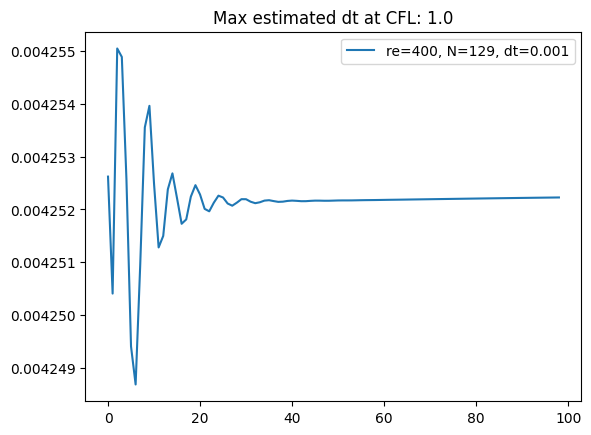

In [6]:
CFL = 1.0
for r in results[:-1]:
    r.max_dt_over_time(CFL, False)
results[-1].max_dt_over_time(CFL)

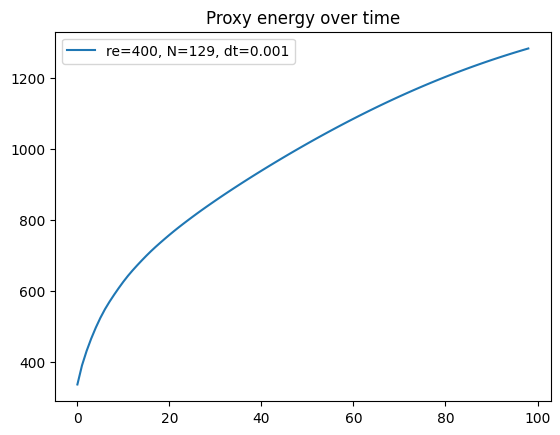

In [7]:
for r in results[:-1]:
    r.energy_over_time(False)
results[-1].energy_over_time()

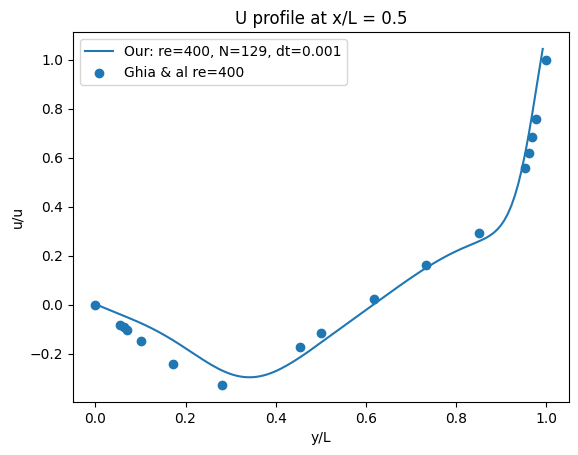

In [9]:
snap = 98
for r in results[:-1]:
    r.profile_at_time(snap, True, False)
results[-1].profile_at_time(snap)

In [10]:
results[-1].plot_velocities()